In [3]:
#Installs
!pip install matplotlib
!pip install nltk
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install scikit-learn
!pip install imbalanced-learn
!pip install transformers
!pip install torch
!pip install sentencepiece
!pip install xgboost

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------------------- -- 7.6/8.1 MB 42.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 29.3 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 24.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     ---------------------- ----------------- 9.2/16.3 MB 43.9 MB/s eta 0:00:01
     --------------------------------------- 16.3/16.3 MB 39.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Requirements
import spacy  
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import re  
import nltk 
from nltk.corpus import stopwords  
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#import du fichier 

file_path = os.path.join(os.getcwd(), "20220913_offers.csv")
df = pd.read_csv(file_path, sep=";", low_memory=False)

columns = ["job_title", "contractType", "description_job","description_profil", "description_entreprise","entreprise_nom"]
df = df[columns]
df['offre_emploi'] = df[['description_job', 'description_profil', 'description_entreprise']].apply(
    lambda x: ' '.join(x.dropna()), axis=1
)

print(df.head())

In [ ]:
df["offre_emploi"] = df["offre_emploi"].str.lower()

nltk.download('stopwords')  
stop_words = set(stopwords.words('french'))

nlp = spacy.load("fr_core_news_sm")

# Fonction de nettoyage avec lemmatisation
def clean_and_lemmatize(text):
    if isinstance(text, str):  
        text = text.lower()  # Minuscule
        text = re.sub(r'\d+', '', text)  # Suppression des chiffres
        text = re.sub(r'[^\w\s]', '', text)  # Suppression de la ponctuation
        doc = nlp(text)  # Analyse du texte avec SpaCy
        words = [token.lemma_ for token in doc if token.text not in stop_words]  # Lemmatisation + suppression stopwords
        return " ".join(words)  # Reconstituer le texte nettoyé
    return ""

df["offre_emploi"] = df["offre_emploi"].apply(clean_and_lemmatize)

**I.** Approche naïve

In [ ]:
#première classification : on regarde le nombre d'occurrences de chaque mot associé à chaque 
#catégorie, à partir de là on établit un score pour chaque catégorie et on assigne à une offre 
#d'emploi la catégorie pour laquelle le score est le plus élevé 

def classify_offer(text, keywords_dict):
    scores = {category: 0 for category in keywords_dict}
    
    for category, keywords in keywords_dict.items():
        scores[category] += sum(text.count(keyword) for keyword in keywords)
    
    return max(scores, key=scores.get) if max(scores.values()) > 0 else "inconnu"

#dictionnaire avec mots clés :

keywords_dict = {
    "Excellence, Leadership et Performance": [
        "leader", "leadership", "lead", "diriger", "décider", "excellence", "exceller", "haut niveau", "prestigieux", "prestige", "réputation", "réputé", "certification",
        "expert", "expertise", "compétence", "qualifié", "qualité", "performance", "performant", "responsabilité"
    ],
    "Accompagnement et Evolution Professionnelle": [
        "accompagnement", "accompagner", "évolution", "évoluer", "formation", "formation continu", "développement", "développer", "carrière", "professionnel", "promotion",
        "succès", "opportunité", "soutien"
    ],
    "Proximité et Ancrage Local": [
        "proximité", "ancrage local", "lien", "relation client", "territoire", "local", "régional",
        "implantation", "département", "acteur", "région"
    ],
    "Relations Humaines et Collectif": [
        "esprit déquipe", "équipe", "familial", "convivialité", "convivial", "entraide", "partage", "solidarité", "respect",
        "famille", "cohésion"
    ],
    "Engagement Social et Bien-être": [
        "rse", "social", "citoyen", "planete", "durable", "développement durable", "inclusion", "handicap", "diversité", "impact social",
        "bienêtre", "environnement", "santé"
    ]#,
    #"Innovation et Technologie": [
    #    "innovation", "tech", "technologie", "transformation digital", "croissance", "expansion", "startup", "modernisation", "intelligence artificiel", "ia", "ai", "artificiel", "logiciel",
    #    "inovant", "r&d"
    #]
}

df["valeur_dominante"] = df["offre_emploi"].apply(lambda x: classify_offer(x, keywords_dict))

In [ ]:
#deuxième classification : on fait la même chose mais on accorde davantage de poids aux mots rares
#car ils sont plus discriminants, en utilisant TF-IDF 

#étape 1 : calcul de la fréquence de chaque mot 

liste_valeurs = list(keywords_dict.values())
liste_valeurs = [mot for sous_liste in liste_valeurs for mot in sous_liste]
# On crée une liste avec tous nos mots clefs 
liste1 = []
# On remplit une liste vide par les fréquences des mots clefs associés à liste_valeurs
for mot in liste_valeurs:
    i = 0
    for k in df["offre_emploi"]:
        i += len(re.findall(r'\b' + re.escape(mot) + r'\b', k))
    liste1+= [i]
a=sum(liste1)
liste2 = [x / a for x in liste1]
print(liste2)
print(liste_valeurs)

#étape 2 : calcul de la fréquence inverse de chaque terme (mesure de l'importance du terme dans l'ensemble du corpus)

N = len(df)
idf_dict = {}
for mot in liste_valeurs:
    DF = 0
    for k in df["offre_emploi"]:
        # Vérifier que k est une chaîne et que le mot apparaît dans l'offre
        if isinstance(k, str) and re.search(r'\b' + re.escape(mot) + r'\b', k):
            DF += 1
    idf_dict[mot] = math.log(N / (1 + DF))

def classify_offer2(offre): 
    scores = {category: 0 for category in keywords_dict}
    
    for category, keywords in keywords_dict.items():
        scores[category] += sum(offre.count(keyword)*idf_dict.get(keyword, 0) for keyword in keywords)
    
    return max(scores, key=scores.get) if max(scores.values()) > 0 else "inconnu"


df["valeur_dominante_2"] = df["offre_emploi"].apply(lambda x: classify_offer2(x))

**II.** Modèle non-supervisé : K-means clustering (**à modifier**)

Aperçu du DataFrame :
                    entreprise_nom  \
0                 Triangle Intérim   
1                          Abalone   
2                   123webimmo.com   
3  Fondation des Amis de l'Atelier   
4                           WEETEC   

                                     description_job  \
0  La société TRIANGLE, entreprise à taille humai...   
1  Nous recherchons un BOUCHER INDUSTRIEL (H/F) E...   
2  En tant qu’agent commercial immobilier au sein...   
3  Au sein de l'équipe de Direction, vous partici...   
4  Rattaché(e) au responsable d’affaire, vos prin...   

                                job_title  \
0         Technicien de maintenance (H/F)   
1                           Boucher (H/F)   
2             Conseiller immobilier (H/F)   
3  Cadre administratif et financier (H/F)   
4                  Chef de chantier (H/F)   

                                  description_profil  \
0  Vous avez des connaissances en maintenance ind...   
1  De formation CAP Boucherie

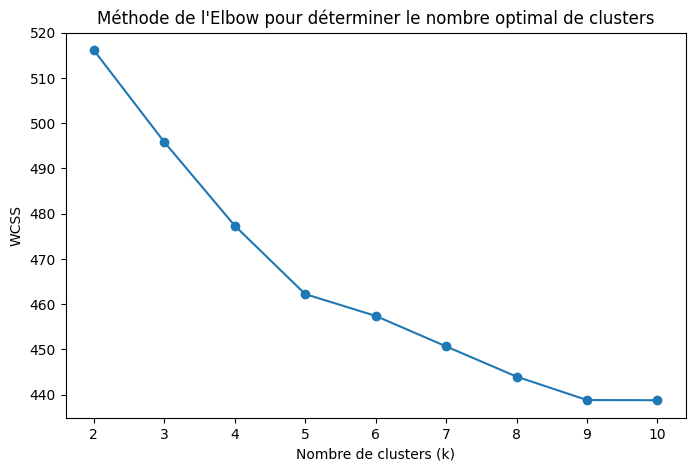


Nombre de clusters choisi (optimal_k) : 5

Fichier de clustering sauvegardé : c:\Users\stani\statapp\kmeans_clusters.csv


In [6]:
from transformers import CamembertTokenizer, CamembertModel
from sklearn.cluster import KMeans

# 1. Chargement du fichier CSV lemmatisé
# Ici on suppose que le fichier se trouve dans le dossier courant.
# Ajuste le séparateur si besoin (dans cet exemple, on utilise la virgule).
file_path = os.path.join(os.getcwd(), "lematised700.csv")
df = pd.read_csv(file_path, sep=",", low_memory=False)

# Affichage rapide des premières lignes pour vérifier
print("Aperçu du DataFrame :")
print(df.head())

# 2. Création de la colonne 'offre_emploi' en fusionnant toutes les colonnes sauf 'catégories'
# On utilise ici une fusion de toutes les colonnes dont le nom (en minuscule) n'est pas 'catégories'
cols_to_merge = [col for col in df.columns if col.lower() != "catégories"]
df["offre_emploi"] = df[cols_to_merge].apply(lambda x: " ".join(x.dropna().astype(str)), axis=1)

# Vérification rapide de la nouvelle colonne
print("\nAperçu de la colonne 'offre_emploi' fusionnée :")
print(df["offre_emploi"].head())

# 3. Extraction des embeddings pour chaque offre d'emploi avec Camembert
model_name = "camembert-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertModel.from_pretrained(model_name)
model.to(device)
model.eval()

def embed_text(text):
    inputs = tokenizer(text,
                       return_tensors="pt",
                       truncation=True,
                       padding="max_length",
                       max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Extraction de la représentation du premier token ([CLS])
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

print("\nCalcul des embeddings avec Camembert (cela peut prendre quelques minutes)...")
texts = df["offre_emploi"].tolist()
embeddings = np.array([embed_text(text) for text in texts])
print("Embeddings calculés :", embeddings.shape)

# 4. Elbow Method pour déterminer le nombre optimal de clusters
wcss = []  # Within-Cluster Sum of Squares
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Affichage du graphique Elbow pour visualiser la diminution de WCSS
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("WCSS")
plt.title("Méthode de l'Elbow pour déterminer le nombre optimal de clusters")
plt.show()

# À partir du graphique, choisissons par exemple k = 5 (adapte ce nombre si besoin)
optimal_k = 5
print("\nNombre de clusters choisi (optimal_k) :", optimal_k)

# 5. Application de KMeans avec initialisation k-means++
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Ajout des labels de cluster au DataFrame initial
df["cluster"] = cluster_labels

# 6. Création d'un DataFrame final regroupant les offres par cluster
clusters_dict = {}
for cluster in range(optimal_k):
    # Liste des offres appartenant à ce cluster
    offers = df[df["cluster"] == cluster]["offre_emploi"].tolist()
    clusters_dict[f"cluster_{cluster}"] = offers

# Pour avoir le même nombre de lignes par colonne, compléter avec NaN
max_offers = max(len(lst) for lst in clusters_dict.values())
for key in clusters_dict:
    clusters_dict[key] += [np.nan] * (max_offers - len(clusters_dict[key]))

df_clusters = pd.DataFrame(clusters_dict)

# Sauvegarde du résultat dans un CSV (séparateur ;)
output_path = os.path.join(os.getcwd(), "kmeans_clusters.csv")
df_clusters.to_csv(output_path, sep=";", index=False, encoding="utf-8")
print("\nFichier de clustering sauvegardé :", output_path)


Nombre d'offres par cluster :
cluster_0    116
cluster_1    147
cluster_2     93
cluster_3     68
cluster_4    165
dtype: int64


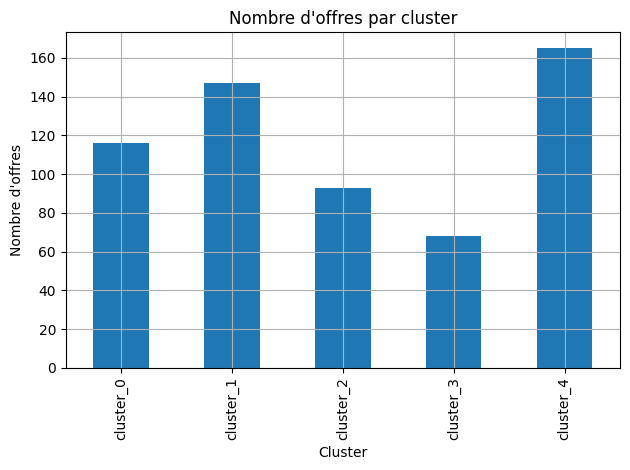

In [7]:
# Chargement du fichier de clustering
df_clusters = pd.read_csv("kmeans_clusters.csv", sep=";", low_memory=False)

# Comptage du nombre d'offres non nulles dans chaque cluster
cluster_counts = df_clusters.notna().sum()

# Affichage des résultats
print("Nombre d'offres par cluster :")
print(cluster_counts)

cluster_counts.plot(kind='bar')
plt.title("Nombre d'offres par cluster")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'offres")
plt.grid(True)
plt.tight_layout()
plt.show()

**III.**    Modèles supervisés

In [3]:
#import du fichier 

file_path = os.path.join(os.getcwd(), "700offers.200classified.csv")
df = pd.read_csv(file_path, sep=",", low_memory=False)

df['offre_emploi'] = df[['description_job', 'description_profil', 'description_entreprise']].apply(
    lambda x: ' '.join(x.dropna()), axis=1
)

print(df.head())
print(df.columns)

                    entreprise_nom  \
0                 Triangle Intérim   
1                          Abalone   
2                   123webimmo.com   
3  Fondation des Amis de l'Atelier   
4                           WEETEC   

                                     description_job  \
0  La société TRIANGLE, entreprise à taille humai...   
1  Nous recherchons un BOUCHER INDUSTRIEL (H/F) E...   
2  En tant qu’agent commercial immobilier au sein...   
3  Au sein de l'équipe de Direction, vous partici...   
4  Rattaché(e) au responsable d’affaire, vos prin...   

                                job_title  \
0         Technicien de maintenance (H/F)   
1                           Boucher (H/F)   
2             Conseiller immobilier (H/F)   
3  Cadre administratif et financier (H/F)   
4                  Chef de chantier (H/F)   

                                  description_profil  \
0  Vous avez des connaissances en maintenance ind...   
1  De formation CAP Boucherie Travail physique, r..

In [4]:
#création du csv lematised700.csv (qu'on utilisera/modifiera)
df["offre_emploi"] = df["offre_emploi"].str.lower()

nltk.download('stopwords')  
stop_words = set(stopwords.words('french'))

nlp = spacy.load("fr_core_news_sm")

# Fonction de nettoyage avec lemmatisation
def clean_and_lemmatize(text):
    if isinstance(text, str):  
        text = text.lower()  # Minuscule
        text = re.sub(r'\d+', '', text)  # Suppression des chiffres
        text = re.sub(r'[^\w\s]', '', text)  # Suppression de la ponctuation
        doc = nlp(text)  # Analyse du texte avec SpaCy
        words = [token.lemma_ for token in doc if token.text not in stop_words]  # Lemmatisation + suppression stopwords
        return " ".join(words)  # Reconstituer le texte nettoyé
    return ""

df["offre_emploi"] = df["offre_emploi"].apply(clean_and_lemmatize)
df.to_csv("lematised700.csv", sep=",", index=False, encoding='utf-8')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1) Régression logistique en TF-IDF embedding

In [15]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Filtrer pour conserver uniquement les lignes avec catégorie (excluant les NaN)
df = df.dropna(subset=['catégories'])
df['catégories'] = df['catégories'].astype(int)

# Vérification de la répartition des classes
print("Répartition des classes:")
print(df['catégories'].value_counts())

# Séparation des données en ensembles d'entraînement et de test (80%/20% avec stratification)
X = df["offre_emploi"]
y = df["catégories"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Création du pipeline ---
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500))
])

# --- Validation croisée ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Validation croisée (5-fold) sur l'ensemble d'entraînement...")
scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print("Scores F1 Macro pour chaque fold :", scores)
print("F1 Macro moyen :", scores.mean())

# --- Entraînement final sur l'ensemble d'entraînement ---
pipeline.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Affichage du rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Répartition des classes:
catégories
2    53
1    49
3    36
4    31
5    27
Name: count, dtype: int64
Validation croisée (5-fold) sur l'ensemble d'entraînement...


c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\stani\AppData\Local\Programs\Python\P

Scores F1 Macro pour chaque fold : [0.18275862 0.17056277 0.17411765 0.18544061 0.1837037 ]
F1 Macro moyen : 0.17931667100835458
Rapport de classification :
              precision    recall  f1-score   support

           1       0.47      0.70      0.56        10
           2       0.38      0.82      0.51        11
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.40        40
   macro avg       0.17      0.30      0.21        40
weighted avg       0.22      0.40      0.28        40



c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

1) Résultats

Répartition des classes:
catégories
2    53
1    49
3    36
4    31
5    27

Régression logistique; vectorisation en TF-IDF; sur 200 lignes (données labelisées) : 

Rapport de classification :

              precision  ;  recall ; f1-score  ; support              
           1       0.47      0.70      0.56        10
           2       0.38      0.82      0.51        11
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.40        40
    macro avg       0.17      0.30      0.21        40
    weighted avg       0.22      0.40      0.28        40

Commentaire :

2) Régression logistique en CamemBERT embedding

In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from transformers import CamembertTokenizer, CamembertModel

# Garder seulement les lignes où 'catégories' n'est pas NaN et convertir en int
df = df.dropna(subset=['catégories'])
df['catégories'] = df['catégories'].astype(int)

# Séparation en ensemble d'entraînement et de test (80%/20% en stratifiant)
X = df["offre_emploi"]
y = df["catégories"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Définition du transformeur Camembert ---
class CamembertVectorizer(BaseEstimator, TransformerMixin):
    """
    Transformeur scikit-learn qui convertit un texte en un vecteur d'embedding
    à l'aide du modèle Camembert.
    """
    def __init__(self, model_name='camembert-base', device='cpu', max_length=512):
        self.model_name = model_name  # Nécessaire pour le clonage dans CV
        self.device = device
        self.max_length = max_length
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name)
        self.model = CamembertModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embeddings = []
        for text in X:
            # Tokenisation avec troncature et padding
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=self.max_length
            )
            # Déplacer les tenseurs sur le device (CPU ou GPU)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Extraction de la représentation du token [CLS] (premier token)
            emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(emb)
        return np.array(embeddings)

# Définir le device (utiliser "cuda" si disponible, sinon "cpu")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Construction du pipeline Camembert + Régression Logistique ---
pipeline_camembert = Pipeline([
    ('camembert', CamembertVectorizer(device=device)),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500))
])

# --- Validation croisée ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Validation croisée (5-fold) sur l'ensemble d'entraînement...")
scores = cross_val_score(pipeline_camembert, X_train, y_train, cv=cv, scoring='f1_macro')
print("Scores F1 Macro pour chaque fold :", scores)
print("F1 Macro moyen :", scores.mean())

# --- Entraînement final ---
print("Entraînement final du modèle sur tout l'ensemble d'entraînement...")
pipeline_camembert.fit(X_train, y_train)

# Prédiction sur l'ensemble de test et affichage du rapport de classification
y_pred = pipeline_camembert.predict(X_test)
print("Camembert-based Classification Report:")
print(classification_report(y_test, y_pred))

Validation croisée (5-fold) sur l'ensemble d'entraînement...


c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\stani\AppData\Local\Programs\Python\P

Scores F1 Macro pour chaque fold : [0.29812994 0.21238095 0.35288221 0.45320856 0.29482402]
F1 Macro moyen : 0.3222851341685639
Entraînement final du modèle sur tout l'ensemble d'entraînement...


c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Camembert-based Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.70      0.56        10
           2       0.46      0.55      0.50        11
           3       0.14      0.14      0.14         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.35        40
   macro avg       0.21      0.28      0.24        40
weighted avg       0.27      0.35      0.30        40



2) Résultats

Régression logistique ; embbeding en Camembert ; sur 200 lignes (données labelisées)

Camembert-based Classification Report:

              precision  ;  recall ; f1-score ;  support
           1       0.47      0.70      0.56        10
           2       0.46      0.55      0.50        11
           3       0.14      0.14      0.14         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.35        40
    macro avg       0.21      0.28      0.24        40
    weighted avg       0.27      0.35      0.30        40

Commentaire :

3) Random Forests

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import CamembertTokenizer, CamembertModel
from imblearn.pipeline import Pipeline  # Pipeline compatible avec imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

df = df.dropna(subset=['catégories'])
df['catégories'] = df['catégories'].astype(int)

# Séparation en ensemble d'entraînement et de test (stratification)
X = df["offre_emploi"]
y = df["catégories"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# --- Définition du transformeur Camembert ---
class CamembertVectorizer(BaseEstimator, TransformerMixin):
    """
    Transformeur qui convertit un texte en un vecteur d'embedding
    à l'aide du modèle Camembert.
    """
    def __init__(self, model_name='camembert-base', device='cpu', max_length=512):
        self.model_name = model_name
        self.device = device
        self.max_length = max_length
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name)
        self.model = CamembertModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        embeddings = []
        for text in X:
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=self.max_length
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Extraction de la représentation du token [CLS] (premier token)
            emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(emb)
        return np.array(embeddings)

# --- Wrapper pour oversampling ---
class OversampleTransformer(BaseEstimator, TransformerMixin):
    """
    Wrapper qui intègre un oversampler et fournit les méthodes fit et transform.
    Pendant l'entraînement, il applique fit_resample.
    En phase de prédiction, il renvoie simplement les données X.
    """
    def __init__(self, sampler):
        self.sampler = sampler

    def fit(self, X, y=None):
        self.X_res_, self.y_res_ = self.sampler.fit_resample(X, y)
        return self

    def transform(self, X):
        return X

# Définir le device (GPU si disponible)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Construction du pipeline avec oversampling et Random Forest ---
pipeline_camembert_rf = Pipeline([
    ('camembert', CamembertVectorizer(device=device)),
    ('oversample', OversampleTransformer(RandomOverSampler(random_state=42))),
    ('clf', RandomForestClassifier(n_estimators=300,
                                   max_depth=10,
                                   random_state=42))
])

# --- Validation croisée (5-fold) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Validation croisée (5-fold) sur l'ensemble d'entraînement...")
scores = cross_val_score(pipeline_camembert_rf, X_train, y_train, cv=cv, scoring='f1_macro')
print("Scores F1 Macro pour chaque fold :", scores)
print("F1 Macro moyen :", scores.mean())

# --- Entraînement final sur tout l'ensemble d'entraînement ---
print("Entraînement final du modèle sur tout l'ensemble d'entraînement...")
pipeline_camembert_rf.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_rf = pipeline_camembert_rf.predict(X_test)

# Affichage du rapport de classification final
print("Random Forest + Camembert Classification Report:")
print(classification_report(y_test, y_pred_rf))

Validation croisée (5-fold) sur l'ensemble d'entraînement...
Scores F1 Macro pour chaque fold : [0.17649123 0.26       0.37054454 0.29364706 0.29090909]
F1 Macro moyen : 0.27831838419578353
Entraînement final du modèle sur tout l'ensemble d'entraînement...
Random Forest + Camembert Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.90      0.67        10
           2       0.43      0.55      0.48        11
           3       0.33      0.29      0.31         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.42        40
   macro avg       0.26      0.35      0.29        40
weighted avg       0.31      0.42      0.35        40



3) Résultats

Random Forest + Camembert Classification Report:

              precision   ; recall ; f1-score  ; support
           1       0.53      0.90      0.67        10
           2       0.43      0.55      0.48        11
           3       0.33      0.29      0.31         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.42        40
    macro avg       0.26      0.35      0.29        40
    weighted avg       0.31      0.42      0.35        40

Commentaire :

4) XGB Multiclass

In [13]:
from transformers import CamembertTokenizer, CamembertModel
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Chargement et filtrage des données
df = df.dropna(subset=['catégories'])
df['catégories'] = df['catégories'].astype(int)

X = df["offre_emploi"]
y = df["catégories"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Camembert Vectorizer
class CamembertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='camembert-base', device='cpu', max_length=512):
        self.model_name = model_name
        self.device = device
        self.max_length = max_length
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name)
        self.model = CamembertModel.from_pretrained(model_name).to(device).eval()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        embeddings = []
        for text in X:
            inputs = self.tokenizer(
                text, return_tensors='pt', truncation=True,
                padding='max_length', max_length=self.max_length
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(emb)
        return np.array(embeddings)

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Correction des classes pour commencer à 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Pipeline avec Oversampling + XGBoost
pipeline_camembert_xgb = Pipeline([
    ('camembert', CamembertVectorizer(device=device)),
    ('oversample', RandomOverSampler(random_state=42)),
    ('clf', XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ))
])

# Validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Validation croisée (5-fold)...")
scores = cross_val_score(pipeline_camembert_xgb, X_train, y_train_adj, cv=cv, scoring='f1_macro')
print("Scores F1 Macro pour chaque fold:", scores)
print("F1 Macro moyen:", scores.mean())

# Entraînement final et évaluation
print("Entraînement final sur tout l'ensemble d'entraînement...")
pipeline_camembert_xgb.fit(X_train, y_train_adj)

y_pred = pipeline_camembert_xgb.predict(X_test)
print("Classification Report (Camembert + XGBoost + Oversampling):")
print(classification_report(y_test_adj, y_pred))

Validation croisée (5-fold)...


c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:41:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:23] WARNING: C:\actio

Scores F1 Macro pour chaque fold: [0.25367965 0.30439394 0.34373434 0.32676213 0.23333333]
F1 Macro moyen: 0.29238067780173044
Entraînement final sur tout l'ensemble d'entraînement...


c:\Users\stani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (Camembert + XGBoost + Oversampling):
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.31      0.36      0.33        11
           2       0.20      0.14      0.17         7
           3       0.33      0.33      0.33         6
           4       0.25      0.17      0.20         6

    accuracy                           0.35        40
   macro avg       0.32      0.32      0.32        40
weighted avg       0.33      0.35      0.34        40



4) Résultats :

Classification Report (Camembert + XGBoost + Oversampling):

              precision    recall  f1-score   support
           0       0.50      0.60      0.55        10
           1       0.31      0.36      0.33        11
           2       0.20      0.14      0.17         7
           3       0.33      0.33      0.33         6
           4       0.25      0.17      0.20         6

         accuracy                           0.35        40
         macro avg       0.32      0.32      0.32        40
         weighted avg       0.33      0.35      0.34        40

Commentaire :

5) SVM (kernel RBF, C=1.0, gamma réglé sur 'scale', et une graine pour la reproductibilité.)

In [7]:
from transformers import CamembertTokenizer, CamembertModel
from imblearn.pipeline import Pipeline   # Assure-toi d'utiliser imblearn.pipeline.Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Garder uniquement les lignes où 'catégories' n'est pas NaN et convertir en int
df = df.dropna(subset=['catégories'])
df['catégories'] = df['catégories'].astype(int)

# Séparation en ensemble d'entraînement et de test (80%/20% en stratifiant)
X = df["offre_emploi"]
y = df["catégories"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Définition du transformeur Camembert ---
class CamembertVectorizer(BaseEstimator, TransformerMixin):
    """
    Transformeur qui convertit un texte en un vecteur d'embedding
    à l'aide du modèle Camembert.
    """
    def __init__(self, model_name='camembert-base', device='cpu', max_length=512):
        self.model_name = model_name
        self.device = device
        self.max_length = max_length
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name)
        self.model = CamembertModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embeddings = []
        for text in X:
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=self.max_length
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Extraction de la représentation du token [CLS] (premier token)
            emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(emb)
        return np.array(embeddings)

# --- Wrapper pour oversampling ---
class OversampleTransformer(BaseEstimator, TransformerMixin):
    """
    Wrapper pour intégrer un oversampler dans le pipeline.
    En phase d'entraînement, il applique fit_resample,
    et en phase de prédiction, il renvoie simplement les données X.
    """
    def __init__(self, sampler):
        self.sampler = sampler
        
    def fit(self, X, y=None):
        self.X_res_, self.y_res_ = self.sampler.fit_resample(X, y)
        return self
    
    def transform(self, X):
        return X

# Définir le device (GPU si disponible, sinon CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Construction du pipeline avec oversampling et SVM ---
# Le pipeline est constitué de :
# 1. CamembertVectorizer pour obtenir les embeddings du texte
# 2. Oversampling sur le jeu d'entraînement (RandomOverSampler)
# 3. StandardScaler pour normaliser les features, essentiel pour le SVM
# 4. SVC avec kernel RBF et des hyperparamètres paramétrés sans opti
pipeline_camembert_svm = Pipeline([
    ('camembert', CamembertVectorizer(device=device)),
    ('oversample', OversampleTransformer(RandomOverSampler(random_state=42))),
    ('scaler', StandardScaler()),  # Normalisation des features pour SVM
    ('clf', SVC(
        kernel='rbf',         # Noyau radial
        C=1.0,                # Contrôle de la marge
        gamma='scale',        # Paramètre du kernel
        probability=True,     # Optionnel : permet de prédire des probabilités
        random_state=42
    ))
])

# Entraînement
print("Entraînement du modèle avec Camembert + SVM + Oversampling...")
pipeline_camembert_svm.fit(X_train, y_train)

# Prédiction sur le jeu de test et affichage du rapport de classification
y_pred_svm = pipeline_camembert_svm.predict(X_test)
print("SVM + Camembert Classification Report:")
print(classification_report(y_test, y_pred_svm))

Entraînement du modèle avec Camembert + SVM + Oversampling...
SVM + Camembert Classification Report:
              precision    recall  f1-score   support

           1       0.39      0.70      0.50        10
           2       0.33      0.45      0.38        11
           3       0.20      0.14      0.17         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.33        40
   macro avg       0.18      0.26      0.21        40
weighted avg       0.22      0.33      0.26        40



5) Résultats :

SVM + Camembert Classification Report:

              precision  ;  recall ; f1-score ;  support
           1       0.39      0.70      0.50        10
           2       0.33      0.45      0.38        11
           3       0.20      0.14      0.17         7
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6

    accuracy                           0.33        40
    macro avg       0.18      0.26      0.21        40
    weighted avg       0.22      0.33      0.26        40

Commentaire :